In [1]:
import pandas as pd, numpy as np
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

base_path = Path()
data_path = base_path.joinpath('data')

In [2]:
#Import data
inflation_df = pd.read_csv(data_path.joinpath('federal inflation rate.csv'), header=0, names=['year', 'inflation'])
house_price_df = pd.read_csv(data_path.joinpath('house price.csv'), header=0, names=['year', 'house price'])
mean_family_income_df = pd.read_csv(data_path.joinpath('mean family income.csv'), header=0, names=['year', 'mean family income'])

#set all dataframe year column to datetime
inflation_df['year'] = pd.to_datetime(inflation_df['year']).dt.year
house_price_df['year'] = pd.to_datetime(house_price_df['year'])
mean_family_income_df['year'] = pd.to_datetime(mean_family_income_df['year']).dt.year

#convert house_price from quarterly to yearly
house_price_df = house_price_df.groupby(house_price_df['year'].dt.year).mean().reset_index()

#round inflation_df inflation column to 2 decimal places
inflation_df['inflation'] = inflation_df['inflation'].round(2)

#find lowest common year in all dataframes and trim dataframes to start that year
lowest_year = max(inflation_df['year'].min(), house_price_df['year'].min(), mean_family_income_df['year'].min())
inflation_df = inflation_df[inflation_df['year'] >= lowest_year]
house_price_df = house_price_df[house_price_df['year'] >= lowest_year]
mean_family_income_df = mean_family_income_df[mean_family_income_df['year'] >= lowest_year]

#find highest common year in all dataframes and trim dataframes to end that year
highest_year = min(inflation_df['year'].max(), house_price_df['year'].max(), mean_family_income_df['year'].max())
inflation_df = inflation_df[inflation_df['year'] <= highest_year]
house_price_df = house_price_df[house_price_df['year'] <= highest_year]

#merge inflation and mean_family_income dataframes
x_info_df = pd.merge(inflation_df, mean_family_income_df, on='year', how='inner')

C:\Users\sebas\AppData\Local\Temp\ipykernel_16692\4115285534.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  house_price_df = house_price_df.groupby(house_price_df['year'].dt.year).mean().reset_index()


In [3]:
#Split the data into training (start to 2011) and testing (2012 to end) sets. This splits the data as close to 80/20 as possible.
x_train = x_info_df[x_info_df['year'] < 2012].drop(columns=['year'])
x_test = x_info_df[x_info_df['year'] >= 2012].drop(columns=['year'])
y_train = house_price_df[house_price_df['year'] < 2012].drop(columns=['year'])
y_test = house_price_df[house_price_df['year'] >= 2012].drop(columns=['year'])

#Create and fit the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

#Use the model to predict the house price for the test data
y_pred = model.predict(x_test)

#Get R2 and MAE scores for the model
r2_score = r2_score(y_test, y_pred)
mae_score = mean_absolute_error(y_test, y_pred)
print(f'R2 Score: {r2_score}')
print(f'MAE Score: {mae_score}')

#Display the actual and predicted house prices for the test data. 
display(pd.DataFrame({
    'Year': house_price_df[house_price_df['year'] >= 2012]['year'],
    'Actual': y_test['house price'], 
    'Predicted': y_pred.flatten().round(2), 
    'Difference': y_test['house price'] - y_pred.flatten().round(2)}))

R2 Score: 0.5835960881494862
MAE Score: 29308.5185819795


,Year,Actual,Predicted,Difference
49,2012,244400.0,235425.71,8974.29
50,2013,266225.0,249362.35,16862.65
51,2014,285775.0,252679.75,33095.25
52,2015,294150.0,263449.56,30700.44
53,2016,305125.0,277813.40,27311.60
54,2017,322425.0,295435.63,26989.37
55,2018,325275.0,303833.25,21441.75
56,2019,320250.0,335053.48,-14803.48
57,2020,336950.0,330650.75,6299.25
58,2021,396800.0,351464.85,45335.15


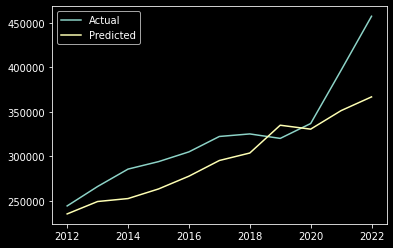

In [4]:
#graph actual vs predicted data with years as the x axis
import matplotlib.pyplot as plt
plt.plot(house_price_df[house_price_df['year'] >= 2012]['year'], y_test['house price'], label='Actual')
plt.plot(house_price_df[house_price_df['year'] >= 2012]['year'], y_pred.flatten().round(2), label='Predicted')
plt.legend()
plt.show()

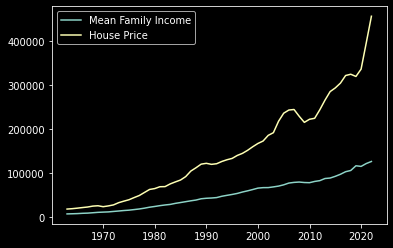

In [5]:
#graph house price vs mean family income with years as the x axis
plt.plot(x_info_df['year'], x_info_df['mean family income'], label='Mean Family Income')
plt.plot(house_price_df['year'], house_price_df['house price'], label='House Price')
plt.legend()
plt.show()

In [12]:
#extract model coeffecients for inflation and mean family income
inflation_coef = model.coef_[0][0]
mean_family_income_coef = model.coef_[0][1]
print(f'Inflation Coefficient: {inflation_coef}')
print(f'Mean Family Income Coefficient: {mean_family_income_coef}')

#get the model's formula
print(f'Formula: house_price = {model.intercept_[0]} + ({inflation_coef} * inflation) + ({mean_family_income_coef} * mean_family_income)')

Inflation Coefficient: 479.8014369724711
Mean Family Income Coefficient: 2.9460282384247294
Formula: house_price = -9616.45790226772 + (479.8014369724711 * inflation) + (2.9460282384247294 * mean_family_income)
